## Transfomer
nn.init

In [21]:
"""%%bash
python3 -m pip install --user torch
python3 -m pip install --user scikit-learn
python3 -m pip install --user imblearn"""

'%%bash\npython3 -m pip install --user torch\npython3 -m pip install --user scikit-learn\npython3 -m pip install --user imblearn'

In [22]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.device_count()
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

1

## Data定義

In [23]:
%%time
#6分ぐらいかかる
df_aal = pd.read_csv('../02_data_analysis/roi_timeseries/timeseries_aal.csv')
df_ho = pd.read_csv('../02_data_analysis/roi_timeseries/timeseries_ho.csv')

#df_dynamic_aal = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_aal.csv')
#df_dynamic_ho = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_ho.csv')

df_subjects_info = pd.read_csv('../02_data_analysis/subjects_info/subjects_info.csv')

CPU times: user 3.03 s, sys: 156 ms, total: 3.18 s
Wall time: 3.22 s


In [24]:
def make_info_data(df = df_subjects_info,col = ['Age','Sex','やる気スコア(Apathy scale)']):
    subID = np.array(df.subID)
    subjects_info_list = []
    for ID in subID:
        data = np.array(df[df.subID == ID][col])[0]
        if 'Sex' in col:
            idx = col.index('Sex')
            if data[idx] == '男':
                data[idx] = 0
            else:
                data[idx] = 1
        subjects_info_list.append(data)
    subjects_info = np.array(subjects_info_list)
    
    for i in range(len(col)):
        if i == idx:
            continue
        else:
            subjects_info[:,i] = (subjects_info[:,i] - np.mean(subjects_info[:,i]))/np.std(subjects_info[:,i])
    return subjects_info.astype(np.float)

def make_data(df, subID = df_subjects_info.subID ,remove_list = ['time','subID']):
    data_list = []
    df_cols = list(df.columns)
    for r in remove_list:
        try:
            df_cols.remove(r)
        except:
            pass
    for ID in df_subjects_info.subID:
        data = df[df.subID == ID][df_cols]
        data = np.array(data)
        data_list.append(data)
    data = np.array(data_list)
    return data

In [25]:
%%time
data_label = make_info_data()
data_aal = make_data(df_aal)
data_ho = make_data(df_ho)

data_label.shape
data_aal.shape
data_ho.shape

CPU times: user 10 s, sys: 19.9 ms, total: 10 s
Wall time: 10 s


(615, 140, 110)

In [26]:
"""%%time
#30秒ぐらいかかる
data_dynamic_aal = make_data(df_dynamic_aal)
data_dynamic_ho = make_data(df_dynamic_ho)

data_dynamic_aal.shape
data_dynamic_ho.shape"""

'%%time\n#30秒ぐらいかかる\ndata_dynamic_aal = make_data(df_dynamic_aal)\ndata_dynamic_ho = make_data(df_dynamic_ho)\n\ndata_dynamic_aal.shape\ndata_dynamic_ho.shape'

## Model作成

In [37]:
import math
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout)
        # Not a parameter
        self.register_buffer('pe', self._pe_table(d_model, max_len))

    def _pe_table(self, d_model: int, max_len: int) -> torch.Tensor:
        pos = torch.arange(0, max_len).unsqueeze(1)
        pe_denominator = torch.exp(
            torch.arange(0, d_model, 2) * math.log(10000) / d_model
        )

        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(pos / pe_denominator)  # 偶数項にはsin
        pe[:, 1::2] = torch.cos(pos / pe_denominator)  # 奇数項にはcos

        pe = pe.unsqueeze(0)  # バッチに対応するため
        return pe

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.dropout(x + self.pe[:, :x.size(1)].clone().detach())
    
class Model(nn.Module):    
    def __init__(self,input_dim,hidden_dim,time_len,nhead,output_dim,hidden_dim_transformer):
        super(Model, self).__init__()
        self.fc   = nn.Linear(input_dim,hidden_dim)
        self.pos  = PositionalEncoding(d_model = hidden_dim,dropout=0.1)
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(hidden_dim,nhead,dropout=0.1)
        self.transformer_encoder       = nn.TransformerEncoder(self.transformer_encoder_layer,
                                                               num_layers=hidden_dim_transformer)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.fc(x)
        x = self.pos(x)
        x = self.transformer_encoder(x)
        x = torch.mean(x,axis=2)
        x = torch.mean(x,axis=1)
        x = torch.reshape(x, (-1, 1))
        x = self.sigmoid(x)
        return x

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, label=None):
        self.data = data
        self.label = label
        self.test = label is None
        self.length = data.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self,idx):
        if self.test:
            data = torch.tensor(self.data[idx])
            return data
        else:
            data = torch.tensor(self.data[idx])
            label = torch.tensor(self.label[idx])
            return data, label

In [39]:
def train_model(data,label,epochs=1000,n_splits=5):
    
    epochs = epochs
    seed = 0
    
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    label_gender = np.array([label[:,1]]).T
    train_all, test, train_all_label, test_label = train_test_split(data,label_gender, train_size = 0.8 ,shuffle=False)
    
    test_dataset = MyDataset(test)
    test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=32)
    
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=n_splits)
    test_pred_all = []
    
    for i, (train_index, val_index) in enumerate(kf.split(train_all)):
        
        early_stopping = 1e5
        save_epochs = 0
        
        train_loss_plot = []
        val_loss_plot = []
        
        train, train_label = train_all[train_index], train_all_label[train_index]
        val,   val_label   = train_all[val_index],   train_all_label[val_index]
        
        input_dim  = train.shape[2]
        #hidden_dim = 8
        hidden_dim = 128
        time_len   = train.shape[1]
        #nhead      = 4
        nhead      = 16
        output_dim = train_label.shape[1]
        hidden_dim_transformer = 1
        
        sm = SMOTE(random_state=42)
        train, train_label = sm.fit_resample(train.reshape(train.shape[0],-1), train_label)
        train = train.reshape(train.shape[0],time_len,input_dim)
        train_label = train_label.reshape(train_label.shape[0],-1)
        
        train_dataset = MyDataset(train,train_label)
        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)

        val_dataset = MyDataset(val,val_label)
        val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=32)
        
        model = Model(input_dim,hidden_dim,time_len,nhead,output_dim,hidden_dim_transformer).to(device)
        
        # 学習させるパラメータを、変数params_to_updateに格納する
        params_to_update = []
        # 学習させないパラメータ
        update_param_names = ["fc1.weight", "fc1.bias"]
        
        # 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
        for name, param in model.named_parameters():
            if name in update_param_names:
                param.requires_grad = False
                print(name)
                print(param)
            else:
                param.requires_grad = True
                params_to_update.append(param)

        criterion = nn.BCELoss()
        optimizer = torch.optim.AdamW(params_to_update)

        def compute_loss(y, t):
            return criterion(y, t)

        def train_step(x,t):
            model.train()
            preds = model(x)
            loss = compute_loss(preds, t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            return loss, preds

        def val_step(x,t):
            model.eval()
            preds = model(x)
            loss = compute_loss(preds, t)    
            return loss, preds

        def test_step(x):
            model.eval()
            preds = model(x)
            return preds

        for epoch in range(epochs):
            train_loss = 0.
            val_loss = 0.
            
            for (x, t) in train_dataloader:
                x, t = x.to(device), t.to(device)
                x = x.float()
                t = t.float()
                loss, preds = train_step(x,t)
                train_loss += loss.item()
            
            for (x, t) in val_dataloader:
                x, t = x.to(device), t.to(device)
                x = x.float()
                t = t.float()
                loss, preds = val_step(x,t)
                val_loss += loss.item()
                
            train_loss /= len(train_dataloader)
            val_loss /= len(val_dataloader)
            if (epoch+1) % 100 == 0:
                print(f'Kfold: {i+1} ::: epoch: {epoch+1}, loss: {train_loss}, val loss: {val_loss}')
            
            if epoch+1 >=100:
                if early_stopping >= val_loss:
                    early_stopping = val_loss
                    model_path = '../02_data_analysis/model/model_gender.pth'
                    torch.save(model.state_dict(), model_path)
                    save_epochs = epoch+1
            
            train_loss_plot.append(train_loss)
            val_loss_plot.append(val_loss)
        
        model.load_state_dict(torch.load(model_path))
        print(f'save_epochs:{save_epochs}')
        
        train_loss_plot = np.array(train_loss_plot)
        val_loss_plot   = np.array(val_loss_plot)
        x               = np.linspace(0, len(train_loss_plot), len(train_loss_plot))
        
        plt.plot(x, train_loss_plot, label="train loss")
        plt.plot(x, val_loss_plot, label="val loss")
        plt.grid()
        plt.show()
        
        train_pred = []
        train_label = []
        
        for (x, t) in train_dataloader:
            x, t = x.to(device), t.to(device)
            x = x.float()
            t = t.float()
            loss, preds = train_step(x,t)
            train_pred.append(preds)
            train_label.append(t)
            
        val_pred = []
        for (x, t) in val_dataloader:
            x, t = x.to(device), t.to(device)
            x = x.float()
            t = t.float()
            loss, preds = val_step(x,t)
            val_pred.append(preds)
            
        for name, param in model.named_parameters():
            if name in update_param_names:
                print(name)
                print(param)
        
        train_pred = torch.cat(train_pred)
        train_pred = train_pred.to('cpu').detach().numpy().copy()
        
        train_label = torch.cat(train_label)
        train_label = train_label.to('cpu').detach().numpy().copy()
        
        val_pred = torch.cat(val_pred)
        val_pred = val_pred.to('cpu').detach().numpy().copy()
        
        plt.scatter(train_label[:,0],np.array(train_pred[:,0]))
        plt.show()
        print(np.mean(train_label[:,0]))
        print(np.corrcoef(train_label[:,0],np.array(train_pred[:,0])))
        
        plt.scatter(val_label[:,0],np.array(val_pred[:,0]))
        plt.show()
        print(np.corrcoef(val_label[:,0],np.array(val_pred[:,0])))
                
        test_pred = []
        for x in test_dataloader:
            x = x.to(device)
            x = x.float()
            preds = test_step(x)
            test_pred.append(preds)
        test_pred = torch.cat(test_pred)
        test_pred = test_pred.to('cpu').detach().numpy().copy()
        test_pred_all.append(test_pred)
    return np.array(test_pred_all),test_label

Kfold: 1 ::: epoch: 100, loss: 0.34576623944135815, val loss: 0.6295385658740997
Kfold: 1 ::: epoch: 200, loss: 0.13614708414444557, val loss: 0.6517298966646194
Kfold: 1 ::: epoch: 300, loss: 0.06361098043047465, val loss: 0.65706767141819
Kfold: 1 ::: epoch: 400, loss: 0.0342706825870734, val loss: 0.6506354808807373
Kfold: 1 ::: epoch: 500, loss: 0.01898355481143181, val loss: 0.6314543634653091
save_epochs:455


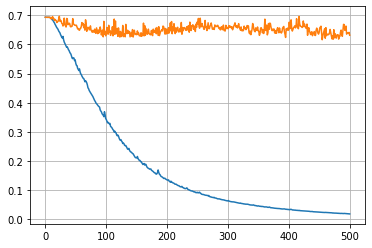

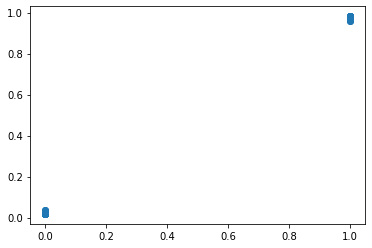

0.5
[[1.         0.99996983]
 [0.99996983 1.        ]]


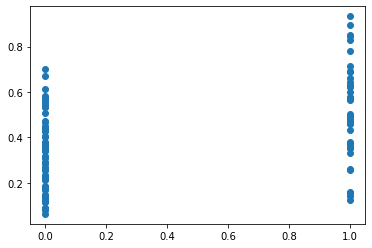

[[1.         0.44384115]
 [0.44384115 1.        ]]
Kfold: 2 ::: epoch: 100, loss: 0.33846257627010345, val loss: 0.5933316871523857
Kfold: 2 ::: epoch: 200, loss: 0.12263882373060499, val loss: 0.5529630407691002
Kfold: 2 ::: epoch: 300, loss: 0.05482075363397598, val loss: 0.548623263835907
Kfold: 2 ::: epoch: 400, loss: 0.028268314099737575, val loss: 0.5484092980623245
Kfold: 2 ::: epoch: 500, loss: 0.015410278059009994, val loss: 0.5566926673054695
save_epochs:494


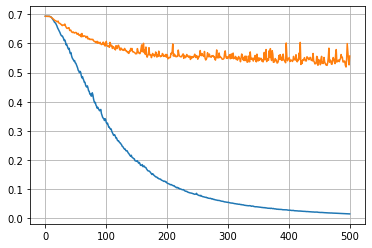

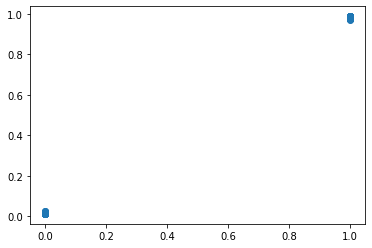

0.5
[[1.         0.99998517]
 [0.99998517 1.        ]]


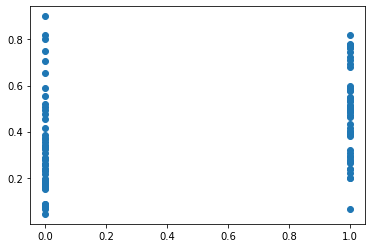

[[1.         0.36702213]
 [0.36702213 1.        ]]
Kfold: 3 ::: epoch: 100, loss: 0.34716252769742695, val loss: 0.5785489827394485
Kfold: 3 ::: epoch: 200, loss: 0.12612519147140638, val loss: 0.558432400226593
Kfold: 3 ::: epoch: 300, loss: 0.05624742859176227, val loss: 0.5461858808994293
Kfold: 3 ::: epoch: 400, loss: 0.028510514114584242, val loss: 0.5413591712713242
Kfold: 3 ::: epoch: 500, loss: 0.015658274359468902, val loss: 0.547083705663681
save_epochs:391


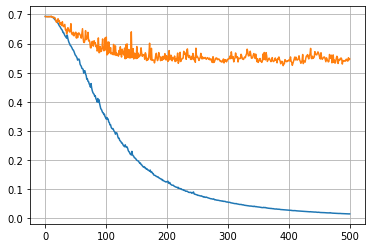

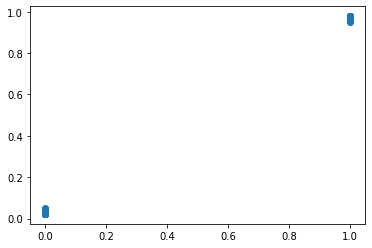

0.5
[[1.         0.99994799]
 [0.99994799 1.        ]]


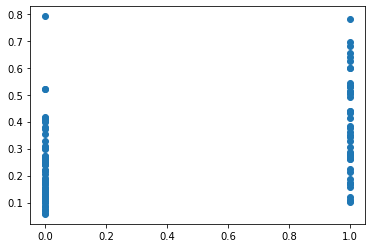

[[1.         0.43112245]
 [0.43112245 1.        ]]
Kfold: 4 ::: epoch: 100, loss: 0.31776374152728487, val loss: 0.6494407057762146
Kfold: 4 ::: epoch: 200, loss: 0.11748734755175454, val loss: 0.7053428590297699
Kfold: 4 ::: epoch: 300, loss: 0.05309839067714555, val loss: 0.6562216579914093
Kfold: 4 ::: epoch: 400, loss: 0.02741464733013085, val loss: 0.6904641389846802
Kfold: 4 ::: epoch: 500, loss: 0.014981851713465793, val loss: 0.7761571556329727
save_epochs:215


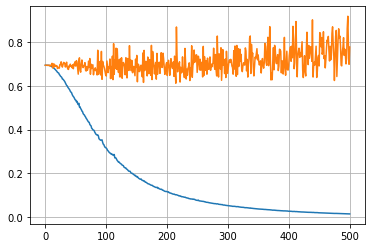

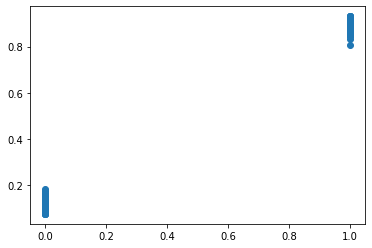

0.5
[[1.         0.99877277]
 [0.99877277 1.        ]]


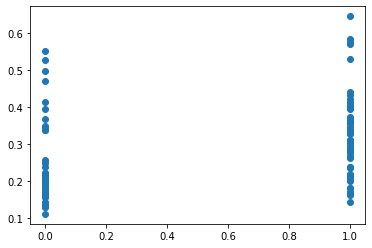

[[1.         0.34875715]
 [0.34875715 1.        ]]
Kfold: 5 ::: epoch: 100, loss: 0.35351282587418187, val loss: 0.6004129499197006
Kfold: 5 ::: epoch: 200, loss: 0.13673121883318975, val loss: 0.5775311589241028
Kfold: 5 ::: epoch: 300, loss: 0.06322886336308259, val loss: 0.5853506326675415
Kfold: 5 ::: epoch: 400, loss: 0.0338818789101564, val loss: 0.5726303979754448
Kfold: 5 ::: epoch: 500, loss: 0.01910016700052298, val loss: 0.5668807327747345
save_epochs:479


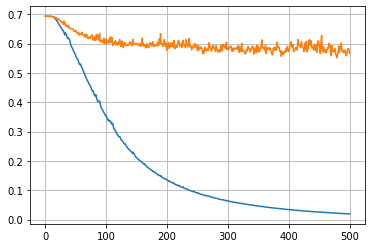

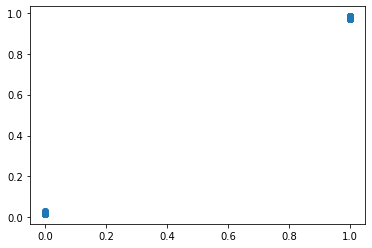

0.5
[[1.         0.99998315]
 [0.99998315 1.        ]]


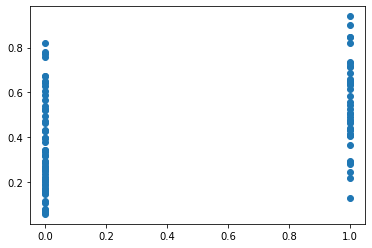

[[1.         0.39683427]
 [0.39683427 1.        ]]


In [40]:
test_pred,test_label = train_model(data_aal,data_label,epochs=500,n_splits=5)

fc1.weight
Parameter containing:
tensor([[0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]],
       device='cuda:0')
fc1.bias
Parameter containing:
tensor([0.], device='cuda:0')
Kfold: 1 ::: epoch: 100, loss: 0.6745145091643701, val loss: 0.6718225330114365
Kfold: 1 ::: epoch: 200, loss: 0.6097344572727497, val loss: 0.6119054406881332
Kfold: 1 ::: epoch: 300, loss: 0.5540287082011883, val loss: 0.591569185256958
Kfold: 1 ::: epoch: 400, loss: 0.49920474336697507, val loss: 0.5757668316364288
Kfold: 1 ::: epoch: 500, loss: 0.4536782663602095, val loss: 0.6054357439279556
save_epochs:434


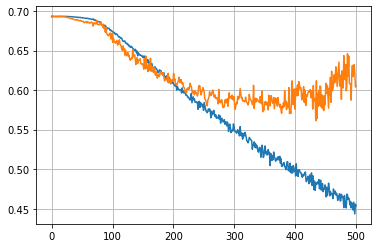

fc1.weight
Parameter containing:
tensor([[0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]],
       device='cuda:0')
fc1.bias
Parameter containing:
tensor([0.], device='cuda:0')


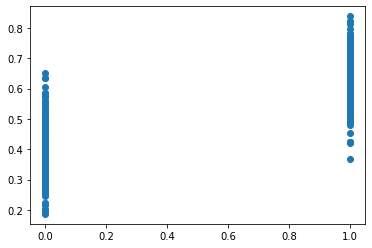

0.5
[[1.         0.81211371]
 [0.81211371 1.        ]]


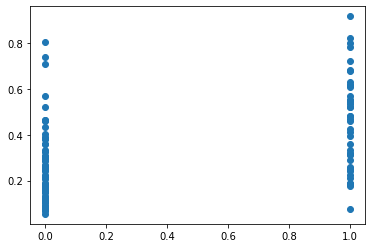

[[1.         0.45987819]
 [0.45987819 1.        ]]
fc1.weight
Parameter containing:
tensor([[0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]],
       device='cuda:0')
fc1.bias
Parameter containing:
tensor([0.], device='cuda:0')
Kfold: 2 ::: epoch: 100, loss: 0.6706950196198055, val loss: 0.6751372814178467
Kfold: 2 ::: epoch: 200, loss: 0.6045979985169002, val loss: 0.6399215161800385
Kfold: 2 ::: epoch: 300, loss: 0.5469409355095455, val loss: 0.6237273812294006
Kfold: 2 ::: epoch: 400, loss: 0.4886869021824428, val loss: 0.6162441000342369
Kfold: 2 ::: epoch: 500, loss: 0.43823929131031036, val loss: 0.6810400187969208
save_epochs:333


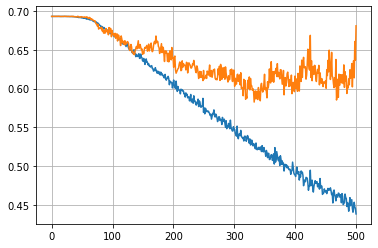

fc1.weight
Parameter containing:
tensor([[0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]],
       device='cuda:0')
fc1.bias
Parameter containing:
tensor([0.], device='cuda:0')


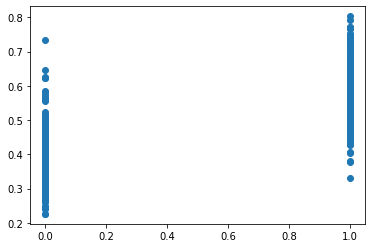

0.5
[[1.         0.74221158]
 [0.74221158 1.        ]]


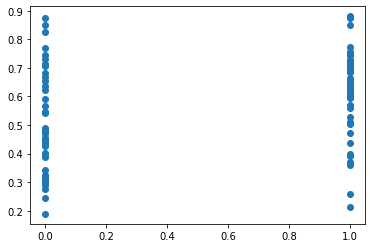

[[1.         0.35661551]
 [0.35661551 1.        ]]
fc1.weight
Parameter containing:
tensor([[0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]],
       device='cuda:0')
fc1.bias
Parameter containing:
tensor([0.], device='cuda:0')
Kfold: 3 ::: epoch: 100, loss: 0.6861766406467983, val loss: 0.7058368623256683
Kfold: 3 ::: epoch: 200, loss: 0.6377604007720947, val loss: 0.6199285909533501
Kfold: 3 ::: epoch: 300, loss: 0.5767317542007991, val loss: 0.5752157717943192


KeyboardInterrupt: 

In [33]:
test_pred,test_label = train_model(data_aal,data_label,epochs=500,n_splits=5)

In [ ]:
plt.scatter(test_label[:,0],test_pred[0,:,0])
np.corrcoef(test_label[:,0],test_pred[0,:,0])

array([[1.        , 0.36639798],
       [0.36639798, 1.        ]])

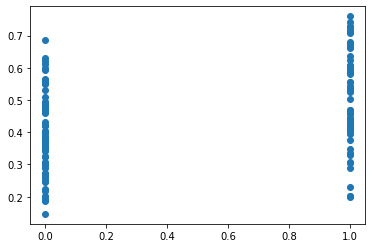

In [179]:
plt.scatter(test_label[:,0],test_pred[1,:,0])
np.corrcoef(test_label[:,0],test_pred[1,:,0])

array([[1.        , 0.29415374],
       [0.29415374, 1.        ]])

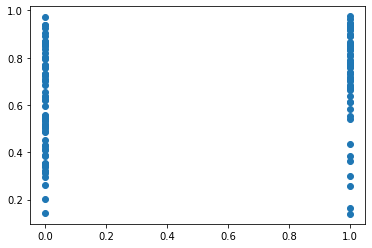

In [180]:
plt.scatter(test_label[:,0],test_pred[2,:,0])
np.corrcoef(test_label[:,0],test_pred[2,:,0])

array([[1.        , 0.28374282],
       [0.28374282, 1.        ]])

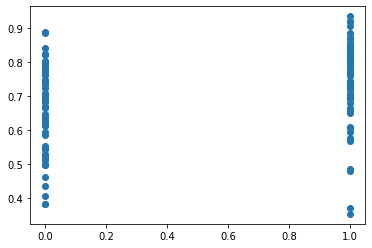

In [181]:
plt.scatter(test_label[:,0],test_pred[3,:,0])
np.corrcoef(test_label[:,0],test_pred[3,:,0])

array([[1.       , 0.3255373],
       [0.3255373, 1.       ]])

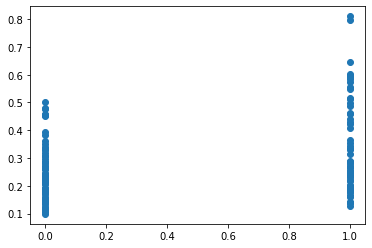

In [182]:
plt.scatter(test_label[:,0],test_pred[4,:,0])
np.corrcoef(test_label[:,0],test_pred[4,:,0])

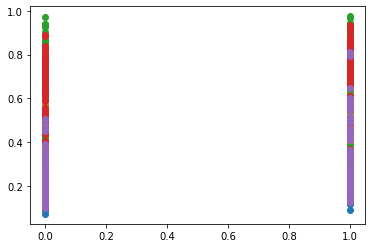

In [183]:
plt.scatter(test_label[:,0],test_pred[0,:,0])
plt.scatter(test_label[:,0],test_pred[1,:,0])
plt.scatter(test_label[:,0],test_pred[2,:,0])
plt.scatter(test_label[:,0],test_pred[3,:,0])
plt.scatter(test_label[:,0],test_pred[4,:,0])

array([[1.       , 0.4026985],
       [0.4026985, 1.       ]])

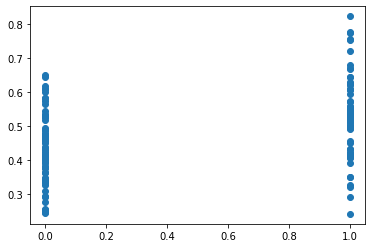

In [184]:
test_pred_mean = test_pred.mean(axis=0)
plt.scatter(test_label[:,0],test_pred_mean[:,0])
np.corrcoef(test_label[:,0],test_pred_mean[:,0])
#0.46427031

In [185]:
from sklearn.metrics import r2_score

print('r^2 train data: ', r2_score(test_label[:,0],test_pred_mean[:,0]))

r^2 train data:  0.13893374421483662


In [186]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(test_label,test_pred_mean[:,0])

LinearRegression()

Text(0.5, 1.0, 'Regression Line')

Text(0.5, 0, 'age')

Text(0, 0.5, 'age predict')

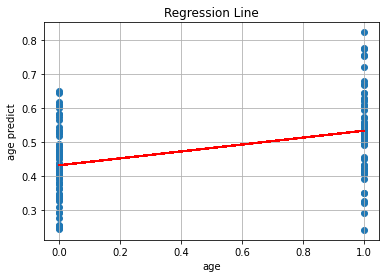

In [187]:
plt.scatter(test_label[:,0],test_pred_mean[:,0])         # 説明変数と目的変数のデータ点の散布図をプロット
plt.plot(test_label[:,0], lr.predict(test_label), color = 'red') # 回帰直線をプロット

plt.title('Regression Line')               # 図のタイトル
plt.xlabel('age') # x軸のラベル
plt.ylabel('age predict')    # y軸のラベル
plt.grid()                                 # グリッド線を表示

plt.show()                                 # 図の表示

In [188]:
diff = test_pred_mean[:,0] - lr.predict(test_label)

In [189]:
_, _, _, label_ = train_test_split(data_aal,data_label, train_size = 0.8 ,shuffle=False)

array([[ 1.        , -0.03868622],
       [-0.03868622,  1.        ]])

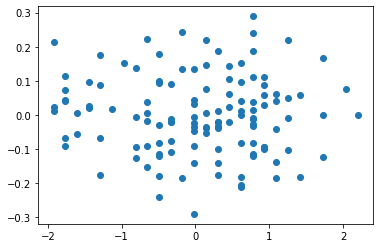

In [190]:
plt.scatter(label_[:,2],diff)
np.corrcoef(label_[:,2],diff)

In [191]:
np.mean(test_pred_mean[:,0])

0.47885665

In [192]:
np.mean(test_label[:,0])

0.46774193548387094